In [4]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

import pysco
import SEdist
from SEdist import SE_distribution

import ast
import os
#import cosmotable
import pysco.cosmotable
import pysco.solver # ` is importing the `solver` module from the `pysco` package. This statement allows you to access and use the functions, classes, and variables defined in the `solver` module within your current Python script or program.
import pysco.initial_conditions
import pysco.integration
import pysco.utils
from typing import Dict
import pandas as pd
import logging
from rich.logging import RichHandler
import iostream
from time import perf_counter
import sys

from SheetUtils import *
# examples/example.py
from pathlib import Path

# Set default figure size (width, height) in inches
plt.rcParams["figure.figsize"] = (8, 6)  # Example: 8 inches wide, 6 inches tall

In [5]:
#path = Path(__file__).parent.absolute()
#"../../examples/pk_lcdmw7v2.dat"
path = "/tmp"
param = {
    "nthreads": 1,
    "theory": "newton",
    # "fR_logfR0": 5,
    # "fR_n": 1,
    # "mond_function": "simple",
    # "mond_g0": 1.2,
    # "mond_scale_factor_exponent": 0,
    # "mond_alpha": 1,
    # "parametrized_mu0": 0.1,
    "H0": 72,
    "Om_m": 0.25733,
    "T_cmb": 2.726,
    "N_eff": 3.044,
    "w0": -1.0,
    "wa": 0.0,
    "boxlen": 200,
    "ncoarse": 7,
    "npart": 256**3,
    "z_start": 29,
    "seed": 42,
    "position_ICS": "center",
    "fixed_ICS": True,
    "paired_ICS": True,
    "dealiased_ICS": False,
    "power_spectrum_file": f"{path}/pk_lcdmw7v2.dat",
    "initial_conditions": "2LPT",
    "base": f"{path}/",
    "z_out": "[10, 5, 2, 1, 0.5, 0]",
    "output_snapshot_format": "HDF5",
    "save_power_spectrum": "yes",
    "integrator": "leapfrog",
    "n_reorder": 500000,
    "mass_scheme": "TSC",
    "Courant_factor": 1.0,
    "max_aexp_stepping": 10,
    "linear_newton_solver": "multigrid",
    "gradient_stencil_order": 5,
    "Npre": 2,
    "Npost": 1,
    "epsrel": 1e-2,
    "extra": "newton_multigrid_ncoarse7",
    "verbose": 1,
}

# Run simulation
#pysco.run(param)
#print("Run completed!")
z_out = ast.literal_eval(param["z_out"])
i = 0
output_directory = f"{param['base']}output_{i:05d}"
power_directory = f"{param['base']}power"
os.makedirs(power_directory, exist_ok=True)
#for i in range(len(z_out) + 1):
#    output_directory = f"{param['base']}/output_{i:05d}"
#    os.makedirs(output_directory, exist_ok=True)

tables = pysco.cosmotable.generate(param)
# aexp and t are overwritten if we read a snapshot
param["aexp"] = 1.0 / (1 + param["z_start"])
pysco.utils.set_units(param)
logging.warning(f"\n[bold blue]----- Initial conditions -----[/bold blue]\n")
p, v = pysco.initial_conditions.generate(param, tables)
p = np.float64(p)

[bold blue]----- Initial conditions -----[/bold blue]



In [6]:
ds, pl = pysco_displacement_field_and_initial_coordinates(p, box=[0,1])
dsl = np.linalg.norm(ds, axis=1)
Ndim = np.int64(p.shape[0]**.333333334) # assume we had Ndim**3 particles in a grid on cubic box
p3d = p.reshape(Ndim,Ndim,Ndim,3)  # reshape the array so we have the Lagrangian coordinates with 3D indexing
# This next step reverses the xyz ordering to zyx ordering and go from C to fortran order and vice versa
# One should read in the initial conditions of a simulation and check that all tetrahedra volumes 
# come out positive. If they are all negative comment out this next line and try again.
p3d = p3d[:,:,:,::-1] 

In [7]:
voxvol = get_voxel_volumes(Ndim-1,p3d)
cen = get_tet_centroids(Ndim-1,p3d)

vol = get_tet_volumes(Ndim-1,p3d)

In [8]:
#downsampled versions
vol2 = get_tet_volumes(Ndim//2-1,p3d[:-1:2,:-1:2,:-1:2,:])
#vol3 = get_tet_volumes(Ndim//3-1,p3d[:-1:3,:-1:3,:-1:3,:])
vol3 = []
for i in range(2):
    for j in range(2):
        for k in range(2):
            vol3 = np.concatenate([vol3, get_tet_volumes(Ndim//3-1,p3d[i:-1:3,j:-1:3,k:-1:3,:]).flatten()])
vol4 = []
ct = 0
for i in range(3):
    for j in range(3):
        for k in range(3):
            ct += 1
#            print(i,j,k, ct)
            vol4 = np.concatenate([vol4, get_tet_volumes(Ndim//4-1,p3d[i:-1:4,j:-1:4,k:-1:4,:]).flatten()])

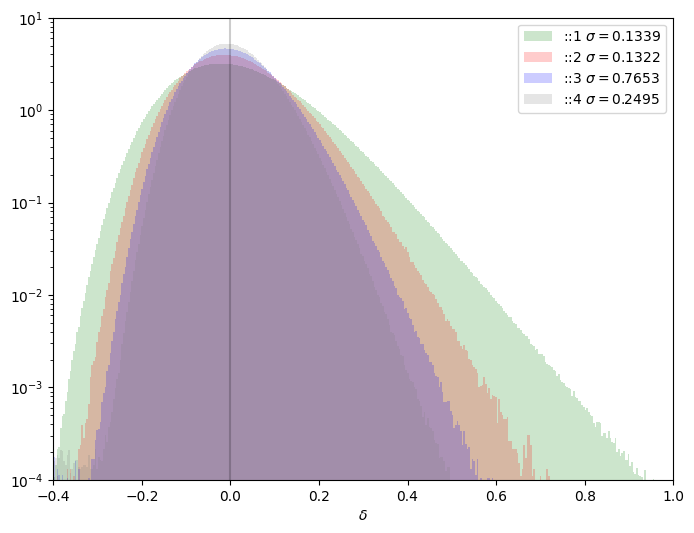

In [9]:
# show the single stream region that is the voids as the regions with positive volume
mpvol = vol[vol > 0].flatten()*Ndim**3*6
mpvol2 = vol2[vol2 > 0].flatten()*Ndim**3*6/2**3
mpvol3 = vol3[vol3 > 0].flatten()*Ndim**3*6/3**3
mpvol4 = vol4[vol4 > 0].flatten()*Ndim**3*6/4**3

std1 = np.std(1./mpvol-1)
std2 = np.std(1./mpvol2-1)
std3 = np.std(1./mpvol3-1)
std4 = np.std(1./mpvol4-1)

nbins = 800
#mvoxvol = np.fabs(voxvol.flatten())/(np.prod(bext)/Ndim**3) # every particle in ICs has volume of 1 this way 
vb = plt.hist(np.abs(1/mpvol)-1,range=[-1,2],bins=nbins,log=True,alpha=0.2,color="green",label=f"::1 $\sigma=${std1:.4g}",density=True)
plt.plot()
vb2 = plt.hist(np.abs(1/mpvol2)-1,range=[-1,2],bins=nbins,log=True,alpha=0.2,color="red",label=f"::2 $\sigma=${std2:.4g}",density=True)
vb3 = plt.hist(np.abs(1/mpvol3)-1,range=[-1,2],bins=nbins,log=True,alpha=0.2,color="blue",label=f"::3 $\sigma=${std3:.4g}",density=True)
vb4 = plt.hist(np.abs(1/mpvol4)-1,range=[-1,2],bins=nbins,log=True,alpha=0.2,color="grey",label=f"::4 $\sigma=${std4:.4g}",density=True)
plt.xlabel(r"$\delta$")
plt.axvline(0,color="black",alpha=0.2)
plt.ylim(1e-4,1e1)
plt.xlim(-0.4,1)
plt.legend();

In [10]:
def get_tet_eigenvalues(Ndim,p3d):
    """ A fast function to compute the centroids of all tetrahedra """
    vert = np.array(( (0,0,0), (1,0,0), (1,1,0), (0,1,0), (0,0,1), (1,0,1), (1,1,1), (0,1,1) ))
    conn = np.array( ( (4,0,7,1), (1,0,7,3), (5,1,4,7), (2,3,1,7), (1,5,6,7), (2,6,7,1) ))
    Ntetpp = len(conn)
    Np = Ndim*Ndim*Ndim
    cen = np.zeros((Np*Ntetpp,3))
    ls  = np.zeros((Np*Ntetpp,3))
    for m in range(Ntetpp):   # 6 tets
        off = vert[conn[m]]
        orig = p3d[off[3][0]:(Ndim+off[3][0]),off[3][1]:(Ndim+off[3][1]),off[3][2]:(Ndim+off[3][2]), :]
        b =  ( p3d[off[1][0]:(Ndim+off[1][0]),off[1][1]:(Ndim+off[1][1]),off[1][2]:(Ndim+off[1][2]), :] \
            - orig ).reshape((Np,3))
        c =  ( p3d[off[2][0]:(Ndim+off[2][0]),off[2][1]:(Ndim+off[2][1]),off[2][2]:(Ndim+off[2][2]), :] \
            - orig ).reshape((Np,3))
        a =  ( p3d[off[0][0]:(Ndim+off[0][0]),off[0][1]:(Ndim+off[0][1]),off[0][2]:(Ndim+off[0][2]), :] \
            - orig).reshape((Np,3))   
        ori = orig.reshape(Np,3)
        cen[m::Ntetpp,:] = ori + ((a+b+c)/4.)
        for i in range(Np):
#            print("o", ori[i], "a", a[i])
            vertices = np.array([ori[i], a[i,:], b[i,:], c[i,:]]-cen[i+m*Np])*Ndim**3
            cov_matrix = np.cov(vertices.T, bias=True)
            ls[i+m*Np,:] = np.linalg.eigvals(cov_matrix)
        
    return np.sort(ls, axis=1)

## 2D PDFs to unify Lagrangian and Eulerian picture

In [52]:
path = "/tmp"
Ndim = 100
param = {
    "nthreads": 8,
    "theory": "newton",
    # "fR_logfR0": 5,
    # "fR_n": 1,
    # "mond_function": "simple",
    # "mond_g0": 1.2,
    # "mond_scale_factor_exponent": 0,
    # "mond_alpha": 1,
    # "parametrized_mu0": 0.1,
    "H0": 72,
    "Om_m": 0.25733,
    "T_cmb": 2.726,
    "N_eff": 3.044,
    "w0": -1.0,
    "wa": 0.0,
    "boxlen": 200,
    "ncoarse": 9,
    "npart": Ndim**3,
    "z_start": 0,
    "seed": 42,
    "position_ICS": "center",
    "fixed_ICS": True,
    "paired_ICS": True,
    "dealiased_ICS": False,
    "power_spectrum_file": f"{path}/pk_lcdmw7v2.dat",
    "initial_conditions": "2LPT",
    "base": f"{path}/",
    "z_out": "[10, 5, 2, 1, 0.5, 0]",
    "output_snapshot_format": "HDF5",
    "save_power_spectrum": "yes",
    "integrator": "leapfrog",
    "n_reorder": 500000,
    "mass_scheme": "TSC",
    "Courant_factor": 1.0,
    "max_aexp_stepping": 10,
    "linear_newton_solver": "multigrid",
    "gradient_stencil_order": 5,
    "Npre": 2,
    "Npost": 1,
    "epsrel": 1e-2,
    "extra": "newton_multigrid_ncoarse9",
    "verbose": 1,
}


In [ ]:
# Generate data for a wide range of masses
blengths = [256, 512,1024,2048,4096,8192,16384,32768,65536]
#blengths = np.int64(np.logspace(np.log10(500),np.log10(25_000),32))
power_directory = f"{param['base']}power"
os.makedirs(power_directory, exist_ok=True)
tables = pysco.cosmotable.generate(param)
# aexp and t are overwritten if we read a snapshot
param["aexp"] = 1.0 / (1 + param["z_start"])
i = 0
fnames = []
volCDFs = []
vol2CDFs = []
vol4CDFs = []
vol10CDFs = []
vol20CDFs = []
for bl in blengths:
    param["boxlen"] = bl # set new parameters
    pysco.utils.set_units(param)
    # make directory
    param["base"] = f"/tmp/box_length_{bl:06d}"
    os.makedirs(param["base"], exist_ok=True)    
    output_directory = f"{param['base']}/output_00000"
    print(output_directory)
    os.makedirs(output_directory, exist_ok=True)
    
    logging.warning(f"\n[bold blue]----- Initial conditions box: {bl:g} -----[/bold blue]\n")
    p, v = pysco.initial_conditions.generate(param, tables)
    fnames.append(output_directory+"particles_newton_multigrid_ncoarse7.h5")
    ds, pl = pysco_displacement_field_and_initial_coordinates(p, box=[0,1])
    dsl = np.linalg.norm(ds, axis=1)
    p3d = p.reshape(Ndim,Ndim,Ndim,3)[:,:,:,::-1]   # reshape the array so we have the Lagrangian coordinates with 3D indexing
    vol = get_tet_volumes(Ndim-1,p3d).flatten()*Ndim**3*6
    lSEdist = SE_distribution(vol,compress="log",Ninterpolants=300)
    volCDFs.append(lSEdist)
    
    vol2 = get_tet_volumes(Ndim//2-1,p3d[:-1:2,:-1:2,:-1:2,:]).flatten()*Ndim**3*6/2**3
    vol2CDFs.append(SE_distribution(vol2,compress="log",Ninterpolants=300))

    vol4 = []
    ct = 0
    for i in range(3):
        for j in range(3):
            for k in range(3):
                vol4 = np.concatenate([vol4, get_tet_volumes(Ndim//4-1,p3d[i:-1:4,j:-1:4,k:-1:4,:]).flatten()*Ndim**3*6/4**3])
    vol4CDFs.append(SE_distribution(vol4,compress="log",Ninterpolants=300))

    vol10 = []
    ct = 0
    for i in range(9):
        for j in range(9):
            for k in range(9):
                vol10 = np.concatenate([vol10, get_tet_volumes(Ndim//10-1,p3d[i:-1:10,j:-1:10,k:-1:10,:]).flatten()*Ndim**3*6/10**3])
    vol10CDFs.append(SE_distribution(vol10,compress="log",Ninterpolants=300))

    
    vol20 = []
    ct = 0
    for i in range(19):
        for j in range(19):
            for k in range(19):
                vol20 = np.concatenate([vol20, get_tet_volumes(Ndim//20-1,p3d[i:-1:20,j:-1:20,k:-1:20,:]).flatten()*Ndim**3*6/20**3])
    vol20CDFs.append(SE_distribution(vol20,compress="log",Ninterpolants=300))
    

[bold blue]----- Initial conditions box: 256 -----[/bold blue]



/tmp/box_length_000256/output_00000


[bold blue]----- Initial conditions box: 512 -----[/bold blue]



/tmp/box_length_000512/output_00000


[bold blue]----- Initial conditions box: 1024 -----[/bold blue]



/tmp/box_length_001024/output_00000


[bold blue]----- Initial conditions box: 2048 -----[/bold blue]



/tmp/box_length_002048/output_00000


[bold blue]----- Initial conditions box: 4096 -----[/bold blue]



/tmp/box_length_004096/output_00000


[bold blue]----- Initial conditions box: 8192 -----[/bold blue]



/tmp/box_length_008192/output_00000


[bold blue]----- Initial conditions box: 16384 -----[/bold blue]



/tmp/box_length_016384/output_00000


[bold blue]----- Initial conditions box: 32768 -----[/bold blue]



/tmp/box_length_032768/output_00000


[bold blue]----- Initial conditions box: 65536 -----[/bold blue]



/tmp/box_length_065536/output_00000


Text(0.5, 1.0, 'z = 0')

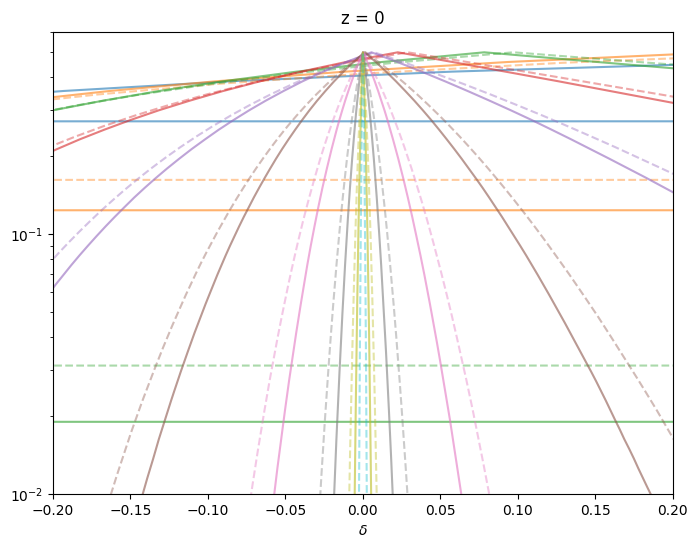

In [ ]:
import itertools
color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
color1 = next(color_cycle)

for i, cdf in enumerate(volCDFs):
    cdf4 = vol4CDFs[i]
    cdf2 = vol2CDFs[i]
#    print(blengths[i]/128 , cdf.std())
    plt.semilogy(1/cdf2.f.x[15:-15]-1, cdf2.pcdf(cdf2.f.x[15:-15]),alpha=0.6,color=color1)
    color1 = next(color_cycle)
    plt.semilogy(1/cdf4.f.x[15:-15]-1, cdf4.pcdf(cdf4.f.x[15:-15]),'--',lw=1.5,alpha=0.4,color=color1)
plt.ylim(1e-2,0.6)
plt.xlim(-.2, .2)
plt.xlabel(r"$\delta$")
plt.title(f"z = {param['z_start']:.3g}")

2.0 3.1998368363823526 1.258723490189109
4.0 1.7142359483850746 0.7566026081959413
8.0 0.7901698295101112 0.39444802181335176
16.0 0.30673404565423945 0.15014611395247016
32.0 0.030952893849886018 0.015235702165064596
64.0 0.012635832219983639 0.006264330631087191
128.0 0.004693827467853069 0.0023358199446417926
256.0 0.0014904331034533908 0.0007428860578509209
512.0 0.00042410352788965647 0.000211533820681104


Text(0.5, 1.0, 'z = 0')

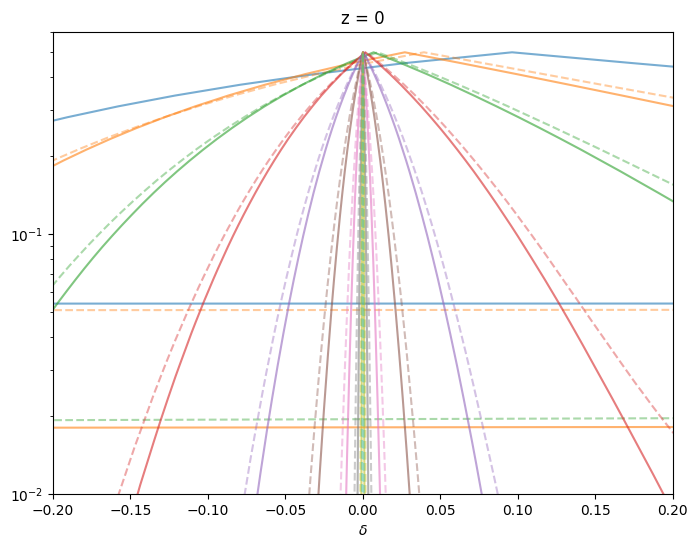

In [ ]:
import itertools
color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
color1 = next(color_cycle)

for i, cdf in enumerate(volCDFs):
    cdf20 = vol20CDFs[i]
    cdf10 = vol10CDFs[i]
    print(blengths[i]/128 , cdf10.std(), cdf20.std())
    plt.semilogy(1/cdf10.f.x[15:-15]-1, cdf10.pcdf(cdf10.f.x[15:-15]),alpha=0.6,color=color1)
    color1 = next(color_cycle)
    plt.semilogy(1/cdf20.f.x[15:-15]-1, cdf20.pcdf(cdf20.f.x[15:-15]),'--',lw=1.5,alpha=0.4,color=color1)
plt.ylim(1e-2,0.6)
plt.xlim(-.2, .2)
plt.xlabel(r"$\delta$")
plt.title(f"z = {param['z_start']:.3g}")

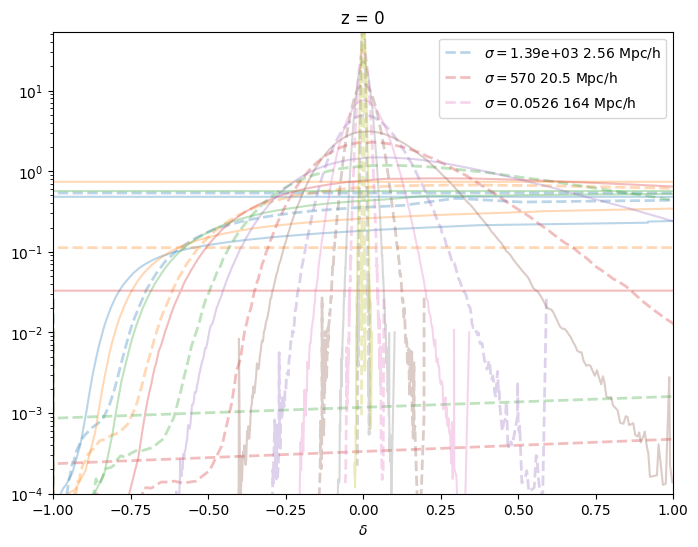

In [27]:
import itertools
color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

for i, cdf in enumerate(volCDFs):
#    print(blengths[i]/Ndim , cdf.std())
    if (i % 3 == 0):
        plabel = f"$\sigma=${cdf.std():.3g} {blengths[i]/Ndim:.3g} Mpc/h"
    else:
        plabel =""
    # Retrieve the color cycle

    color1 = next(color_cycle)
# Get the first color from the cycle
    plt.semilogy(1/cdf.f.x-1, cdf.pdf(cdf.f.x),alpha=0.3,color=color1)
    cdf4 = vol4CDFs[i]
    plt.semilogy(1/cdf4.f.x-1, cdf4.pdf(cdf4.f.x),"--",lw=2,label=plabel,alpha=0.3,color=color1)

plt.ylim(1e-4,53.6)
plt.xlim(-1, 1)
plt.xlabel(r"$\delta$")
plt.title(f"z = {param['z_start']:.3g}")
plt.legend()

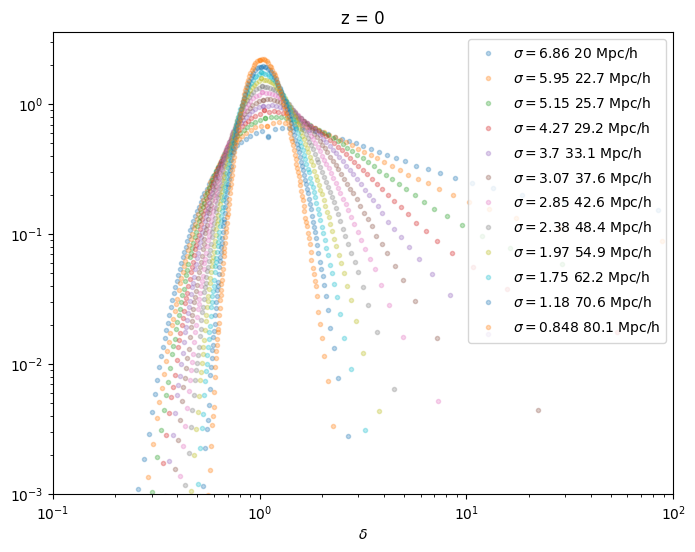

In [22]:
for i, cdf in enumerate(vol4CDFs[:12]):
#    print(blengths[i]/Ndim , cdf.std())
    if (i % 1 == 0):
        plabel = f"$\sigma=${cdf.std():.3g} {blengths[i]/Ndim*4:.3g} Mpc/h"
    else:
        plabel =""
    plt.loglog(1/cdf.f.x, cdf.pdf(cdf.f.x),'.',label=plabel,alpha=0.3)
plt.ylim(1e-3,3.6)
plt.xlim(1e-1, 1e2)
plt.xlabel(r"$\delta$")
plt.title(f"z = {param['z_start']:.3g}")
plt.legend();

In [106]:
Nd = 100
dg = np.logspace(1e-1,1e2,Nd)
NM = len(volCDFs)
dM = blengths/Ndim
pdf2d = np.zeros((Nd,NM))

for i, cdf in enumerate(volCDFs):
    pdf2d[:,i] = cdf.pdf(1/dg)

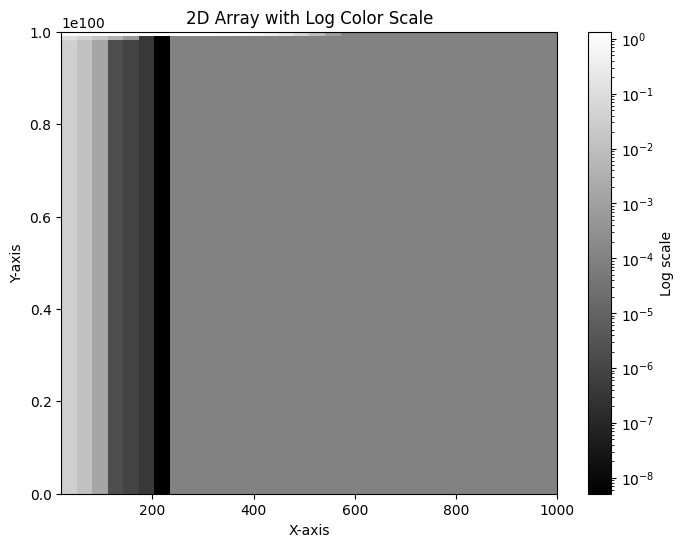

In [107]:
from matplotlib.colors import LogNorm

# Replace zeros with a small positive value
eps = 1e-4  # Small positive value
pdf2d_logsafe = np.where(pdf2d > 0, pdf2d, eps)

# Plot the array with a logarithmic color scale
plt.figure(figsize=(8, 6))
plt.imshow(pdf2d_logsafe, norm=LogNorm(), cmap='grey', extent=[dM[0], dM[-1], dg[0], dg[-1]], aspect='auto')
plt.colorbar(label='Log scale')
plt.title('2D Array with Log Color Scale')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

## Eigenvalue distributions 

In [199]:
Ndim = np.int64(p.shape[0]**.333333334) # assume we had Ndim**3 particles in a grid on cubic box
ls = get_tet_eigenvalues(Ndim-1,p3d)

KeyboardInterrupt: 

In [85]:
len(volCDFs)

32

In [115]:
import numpy as np

# Example vertices of the tetrahedron
vertices = np.array([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 0.0]
])

# Step 1: Compute the centroid
centroid = np.mean(vertices, axis=0)

# Step 2: Shift vertices to have centroid at origin
shifted_vertices = vertices - centroid

# Step 3: Compute the covariance matrix
cov_matrix = np.cov(shifted_vertices.T, bias=True)  # bias=True for population covariance

# Step 4: Compute eigenvalues
eigenvalues = np.sort(np.linalg.eigvals(cov_matrix))

print("Eigenvalues:", eigenvalues)

Eigenvalues: [0.0625 0.25   0.25  ]


In [77]:
np.random.normal(3)

3.7849404054050333

In [51]:
vol3.append(3)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [49]:
for i in range(2):
    print(i)

0
1


In [84]:
p3d.dtype

dtype('float64')